<a href="https://colab.research.google.com/github/profsuccodifrutta/Variational_Autoencoder_for_Anomaly_Detection/blob/main/1_data_loading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Crea una cartella locale su Colab per i dati (veloce)
!mkdir -p /content/dataset_local

# Scompatta il file.
# NOTA: Sostituisci IL_TUO_FILE.zip con il nome reale del tuo file
path_zip = "/content/drive/MyDrive/brainmri.zip"

!unzip -q "{path_zip}" -d /content/dataset_local

print("Scompattamento completato!")

Scompattamento completato!


In [5]:
# Vediamo cosa c'è dentro la cartella locale
#!ls -R /content/dataset_local

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

import os
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms

In [9]:
import glob
import os
import torch
from PIL import Image
from torch.utils.data import Dataset, random_split

# 1. Puntiamo ai dati sani
# Uso il percorso ricorsivo '**' per essere sicuri di trovarli ovunque siano
file_sani = glob.glob("/content/dataset_local/**/Training/notumor/*.jpg", recursive=True)

print(f"--- ANALISI DATASET ---")
print(f"Totale immagini sane trovate: {len(file_sani)}")

# 2. Classe Dataset
class BrainDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        image = Image.open(img_path).convert('L')
        if self.transform:
            image = self.transform(image)
        return image

# 3. Creazione Split (70% Train, 20% Val, 10% Test)
if len(file_sani) > 0:
    full_healthy_ds = BrainDataset(file_sani)

    train_size = int(0.7 * len(full_healthy_ds))
    val_size = int(0.2 * len(full_healthy_ds))
    test_size = len(full_healthy_ds) - train_size - val_size

    train_subset, val_subset, test_healthy_subset = random_split(
        full_healthy_ds, [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )

    print(f"\n--- DISTRIBUZIONE SPLIT (Solo Sani) ---")
    print(f"✅ Training:   {len(train_subset)} immagini (usate per imparare la normalità)")
    print(f"⚠️ Validation: {len(val_subset)} immagini (usate per monitorare l'allenamento)")
    print(f"🛡️ Test Sani:  {len(test_healthy_subset)} immagini (usate per valutare i falsi allarmi)")

    # 4. Recuperiamo le anomalie per il Test finale
    file_anomalie = glob.glob("/content/dataset_local/**/Testing/*/*.jpg", recursive=True)
    # Filtriamo via i sani dalla cartella Testing per avere solo anomalie vere
    file_anomalie = [f for f in file_anomalie if "notumor" not in f]

    print(f"\n--- DATI PER TEST ANOMALIE ---")
    print(f"🚨 Anomalie:  {len(file_anomalie)} immagini (glioma, meningioma, etc.)")
else:
    print("❌ ERRORE: Non ho trovato le immagini. Controlla se la cartella 'Training/notumor' esiste.")

--- ANALISI DATASET ---
Totale immagini sane trovate: 1595

--- DISTRIBUZIONE SPLIT (Solo Sani) ---
✅ Training:   1116 immagini (usate per imparare la normalità)
⚠️ Validation: 319 immagini (usate per monitorare l'allenamento)
🛡️ Test Sani:  160 immagini (usate per valutare i falsi allarmi)

--- DATI PER TEST ANOMALIE ---
🚨 Anomalie:  906 immagini (glioma, meningioma, etc.)


In [10]:
# Controlliamo la dimensione reale della prima immagine del dataset
img_raw = Image.open(train_subset.dataset.file_list[0])
print(f"La dimensione originale dei file è: {img_raw.size}")

La dimensione originale dei file è: (201, 250)


In [11]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

# 1. TRASFORMAZIONI PER IL TRAINING (Con Data Augmentation)
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5), # Specchiamento orizzontale
    transforms.RandomRotation(degrees=10),   # Piccola rotazione per simulare inclinazione testa
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)), # Traslazione e Zoom
    transforms.ToTensor(), # Converte in numero tra 0 e 1
])

# 2. TRASFORMAZIONI PER VALIDATION E TEST (Solo Base)
# Qui non vogliamo rotazioni, vogliamo vedere il dato "puro"
base_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# 3. WRAPPER PER APPLICARE LE TRASFORMAZIONI AI SUBSET
class TransformingDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        # Prendiamo l'immagine originale dal subset
        x = self.subset[index]
        # Applichiamo la trasformazione specifica
        if self.transform:
            x = self.transform(x)
        return x

    def __len__(self):
        return len(self.subset)

# Creiamo i dataset finali "trasformati"
train_data = TransformingDataset(train_subset, transform=train_transform)
val_data = TransformingDataset(val_subset, transform=base_transform)
test_data_sani = TransformingDataset(test_healthy_subset, transform=base_transform)

# 4. CREAZIONE DATALOADERS
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader_sani = DataLoader(test_data_sani, batch_size=batch_size, shuffle=False)

print(f"I DataLoader sono pronti!")
print(f"Ogni batch contiene {batch_size} immagini di dimensione 128x128.")

I DataLoader sono pronti!
Ogni batch contiene 32 immagini di dimensione 128x128.


Formato del batch (Batch_size, Canali, Altezza, Larghezza): torch.Size([32, 1, 128, 128])


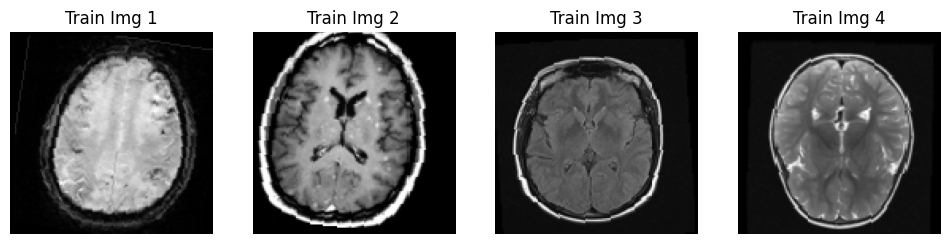

In [12]:
import matplotlib.pyplot as plt

# Estraiamo un batch (32 immagini) dal nostro motore di caricamento
images = next(iter(train_loader))

print(f"Formato del batch (Batch_size, Canali, Altezza, Larghezza): {images.shape}")

# Visualizziamo le prime 4 immagini per vedere l'effetto delle trasformazioni
plt.figure(figsize=(12, 6))
for i in range(4):
    plt.subplot(1, 4, i+1)
    # Squeeze serve per passare da (1, 128, 128) a (128, 128) per il plot
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f"Train Img {i+1}")
    plt.axis('off')
plt.show()